In [1]:
import sys

%load_ext autoreload
%load_ext line_profiler
%autoreload 2


sys.path.append("..")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from matplotlib import rc
from tqdm.notebook import tqdm

from zfista.problems import FDS, FDS_CONSTRAINED, JOS1, JOS1_L1, SD

In [3]:
fig_path = os.path.abspath(os.path.join("./figs"))
data_path = os.path.abspath(os.path.join("./data"))
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
rc("text", usetex=True)
plt.style.use(["science", "bright"])

In [4]:
def generate_start_points(low, high, n_dims, n_samples=1000):
    return [
        np.random.uniform(low=low, high=high, size=n_dims) for _ in range(n_samples)
    ]


def run(
    problem,
    start_points,
    tol=1e-5,
    nesterov=False,
    nesterov_ratio=(0, 0.25),
    n_jobs=-1,
    verbose=False,
):
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(problem.minimize_proximal_gradient)(
            x0,
            tol=tol,
            nesterov=nesterov,
            nesterov_ratio=nesterov_ratio,
            return_all=True,
            verbose=verbose,
        )
        for x0 in start_points
    )
    return results


def show_Pareto_front(
    problem,
    results,
    results_nesterov,
    step=None,
    s=15,
    alpha=0.75,
    fname=None,
    elev=15,
    azim=130,
    linewidths=0.1,
):
    labels = [
        "Starting points",
        f"PGM ($k={step}$)",
        f"Acc-PGM ($k={step}$)",
        "PGM (Solutions)",
        "Acc-PGM (Solutions)",
    ]
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100)
    if problem.m_dims == 2:
        ax = fig.add_subplot(111)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if problem.m_dims == 3:
        ax = fig.add_subplot(111, projection="3d", clip_on=True)
        ax.view_init(elev=elev, azim=azim)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=0.6)
    for _i, (result, result_acc) in tqdm(enumerate(zip(results, results_nesterov))):
        allvecs = result.allvecs
        allvecs_acc = result_acc.allvecs
        x0 = allvecs[0]
        F_of_x0 = problem.f(x0) + problem.g(x0)
        if step is not None:
            xk = allvecs[step]
            xk_acc = allvecs_acc[step]
            F_of_xk = problem.f(xk) + problem.g(xk)
            F_of_xk_acc = problem.f(xk_acc) + problem.g(xk_acc)
        F_pareto = result.fun
        F_pareto_acc = result_acc.fun
        if problem.m_dims == 2:
            ax.scatter(
                *F_of_x0,
                color="#8e44ad",
                marker="x",
                label=labels[0],
                s=s,
                alpha=alpha,
                linewidths=linewidths,
            )
            if step is not None:
                ax.scatter(
                    *F_of_xk,
                    color="#2980b9",
                    marker="<",
                    label=labels[1],
                    s=s,
                    alpha=alpha,
                    linewidths=linewidths,
                )
                ax.scatter(
                    *F_of_xk_acc,
                    facecolors="none",
                    edgecolor="#e74c3c",
                    marker="*",
                    label=labels[2],
                    s=s,
                    alpha=alpha,
                    linewidths=linewidths,
                )
        ax.scatter(
            *F_pareto,
            color="#2980b9",
            marker=".",
            label=labels[3],
            s=s,
            alpha=alpha,
            linewidths=linewidths,
        )
        ax.scatter(
            *F_pareto_acc,
            facecolors="none",
            edgecolors="#e74c3c",
            marker="D",
            label=labels[4],
            s=s,
            alpha=alpha,
            linewidths=linewidths,
        )
    ax.set_xlabel(r"$F_1$", fontsize=15)
    ax.set_ylabel(r"$F_2$", fontsize=15)
    if problem.m_dims == 3:
        ax.set_zlabel(r"$F_3$", fontsize=15)
        ax.legend(labels[-2:], bbox_transform=ax.transData)
    elif step is None:
        ax.legend([labels[0]] + labels[-2:])
    else:
        ax.legend(labels)
    if fname is not None:
        plt.savefig(fig_path + "/" + fname, bbox_inches="tight")


def get_stats(results):
    nits = [result.nit for result in results]
    nit_internals = [result.nit_internal for result in results]
    execution_times = [result.execution_time for result in results]
    stats = {
        "nit": {"mean": np.mean(nits), "std": np.std(nits), "max": np.max(nits)},
        "nit_internal": {
            "mean": np.mean(nit_internals),
            "std": np.std(nit_internals),
            "max": np.max(nit_internals),
        },
        "execusion_time": {
            "mean": np.mean(execution_times),
            "std": np.std(execution_times),
            "max": np.max(execution_times),
        },
    }
    return stats

## JOS1
Minimize
$$
f_1(x) = \frac{1}{n} \| x \|_2^2, \quad f_2(x) = \frac{1}{n} \| x - 2\|_2^2
$$
subject to $x \in \mathbf{R^n}$.

In [5]:
n_dims = 50
problem_JOS1 = JOS1(n_dims=n_dims)
start_points_JOS1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

### Proximal Gradient Method

In [6]:
results_JOS1 = run(problem_JOS1, start_points_JOS1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.7min
/Users/zalgo/.anyenv/envs/pyenv/versions/3.10.10/lib/pyt

### Accelerated Proximal Gradient Method

In [7]:
results_acc_JOS1 = run(problem_JOS1, start_points_JOS1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Complexity

In [8]:
import pprint

stats_JOS1 = {"PGM": get_stats(results_JOS1), "Acc-PGM": get_stats(results_acc_JOS1)}
pprint.pprint(stats_JOS1)

{'Acc-PGM': {'execusion_time': {'max': 2.7815802097320557,
                                'mean': 2.0926460132598876,
                                'std': 0.19141540397360826},
             'nit': {'max': 65, 'mean': 65.0, 'std': 0.0},
             'nit_internal': {'max': 1170,
                              'mean': 952.28,
                              'std': 64.73085508472757}},
 'PGM': {'execusion_time': {'max': 9.976227045059204,
                            'mean': 7.481149582386017,
                            'std': 0.6977661604192146},
         'nit': {'max': 236, 'mean': 231.746, 'std': 1.0542694152824503},
         'nit_internal': {'max': 4242,
                          'mean': 3401.806,
                          'std': 237.59770277508997}}}


0it [00:00, ?it/s]

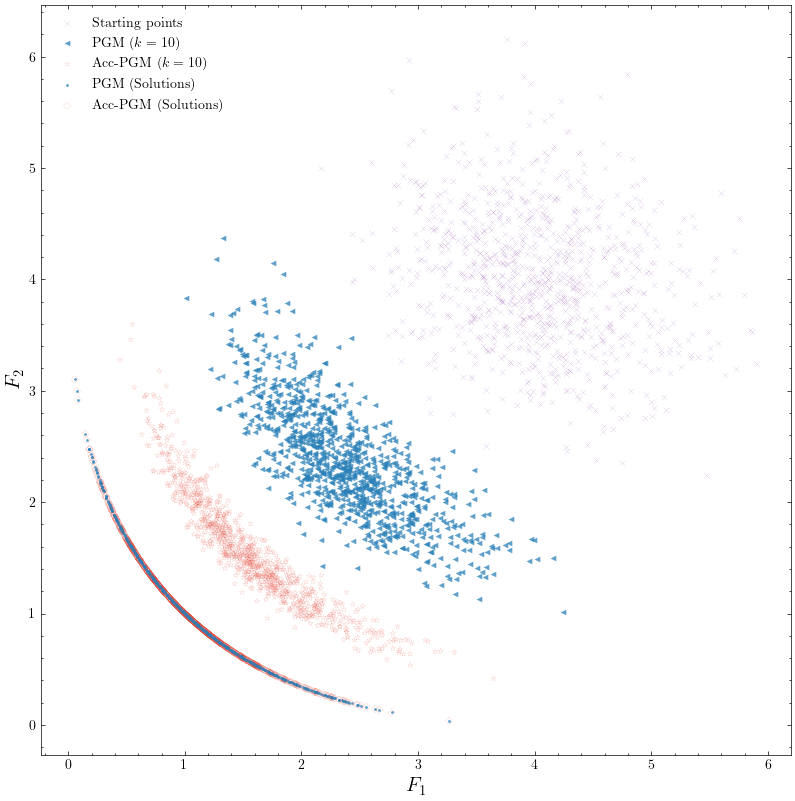

In [9]:
show_Pareto_front(
    problem_JOS1, results_JOS1, results_acc_JOS1, step=10, fname="JOS1.pdf"
)

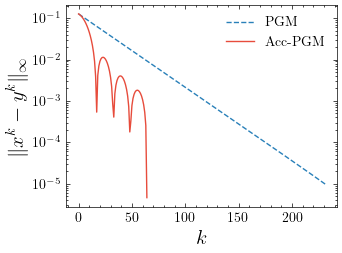

In [10]:
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=15)
plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
plt.plot(
    results_JOS1[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed"
)
plt.plot(results_acc_JOS1[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + "/JOS1_error.pdf", bbox_inches="tight")

## JOS1 + $\ell_1$ penalty
Minimize
$$
F_1(x) = \frac{1}{n} \| x \|_2^2 + \frac{1}{n} \|x\|_1, \quad F_2(x) = \frac{1}{n} \| x - 2\|_2^2 + \frac{1}{2n} \|x - 1\|_1
$$
subject to $x \in \mathbf{R}^n$.

In [11]:
n_dims = 50
problem_JOS1_L1 = JOS1_L1(n_dims=n_dims, l1_ratios=(1 / n_dims, 1 / n_dims / 2))
start_points_JOS1_L1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

### Proximal Gradient Method

In [12]:
results_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.2s
/Users/zalgo/.anyenv/envs/pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
/Users/zalgo/.anyenv/envs/pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. 

### Accelerated Proximal Gradient Method

In [13]:
results_acc_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   45.0s
/Users/zalgo/.anyenv/envs/pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/zalgo/.anyenv/envs/pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. 

### Complexity

In [14]:
stats_JOS1_L1 = {
    "PGM": get_stats(results_JOS1_L1),
    "Acc-PGM": get_stats(results_acc_JOS1_L1),
}
pprint.pprint(stats_JOS1_L1)

{'Acc-PGM': {'execusion_time': {'max': 12.22089409828186,
                                'mean': 7.800320901155472,
                                'std': 1.1757027460106988},
             'nit': {'max': 187, 'mean': 161.216, 'std': 16.46059974606029},
             'nit_internal': {'max': 3631,
                              'mean': 2434.029,
                              'std': 318.6689946621729}},
 'PGM': {'execusion_time': {'max': 54.171611070632935,
                            'mean': 10.701421920776367,
                            'std': 2.173705017024851},
         'nit': {'max': 320, 'mean': 219.759, 'std': 7.796211836526763},
         'nit_internal': {'max': 26144,
                          'mean': 3342.193,
                          'std': 816.4361320709661}}}


0it [00:00, ?it/s]

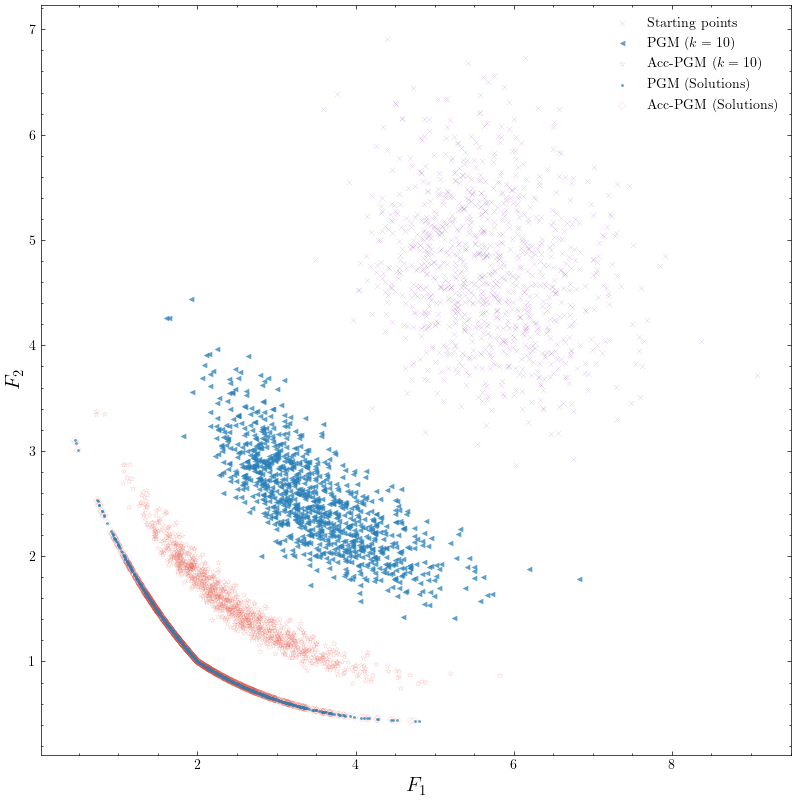

In [15]:
show_Pareto_front(
    problem_JOS1_L1, results_JOS1_L1, results_acc_JOS1_L1, step=10, fname="JOS1_L1.pdf"
)

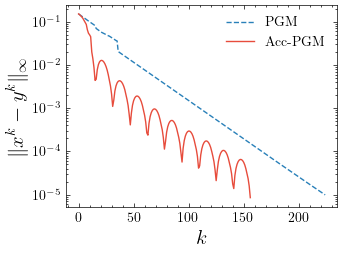

In [16]:
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=15)
plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
plt.plot(
    results_JOS1_L1[0].all_error_criteria,
    color="#2980b9",
    label="PGM",
    linestyle="dashed",
)
plt.plot(results_acc_JOS1_L1[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + "/JOS1_L1_error.pdf", bbox_inches="tight")

## SD
Minimize
$$F_1(x) = 2 x_1 + \sqrt{2} x_2 + \sqrt{2} x_3 + x_4, \quad F_2(x) = \frac{2}{x_1} + \frac{2 \sqrt{2}}{x_2} + \frac{2 \sqrt{2}}{x_3} + \frac{2}{x_4}$$
subject to $(1, \sqrt{2}, \sqrt{2}, 1)^\top \le x \le (3, 3, 3, 3)^\top$.

In [17]:
problem_SD = SD()
start_points_SD = generate_start_points(
    low=problem_SD.lb, high=problem_SD.ub, n_dims=problem_SD.n_dims
)

### Proximal Gradient Method

In [18]:
results_SD = run(problem_SD, start_points_SD)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Accelerated Proximal Gradient Method

In [19]:
results_acc_SD = run(problem_SD, start_points_SD, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Complexity

In [20]:
stats_SD = {"PGM": get_stats(results_SD), "Acc-PGM": get_stats(results_acc_SD)}
pprint.pprint(stats_SD)

{'Acc-PGM': {'execusion_time': {'max': 4.748649835586548,
                                'mean': 2.1035816931724547,
                                'std': 0.5833580472889623},
             'nit': {'max': 70, 'mean': 33.021, 'std': 8.791618679173933},
             'nit_internal': {'max': 1132,
                              'mean': 485.989,
                              'std': 137.77775175622514}},
 'PGM': {'execusion_time': {'max': 6.352782964706421,
                            'mean': 2.280814779281616,
                            'std': 0.8458761188684208},
         'nit': {'max': 95, 'mean': 36.481, 'std': 13.054104297116673},
         'nit_internal': {'max': 1532,
                          'mean': 536.707,
                          'std': 202.62950710841693}}}


0it [00:00, ?it/s]

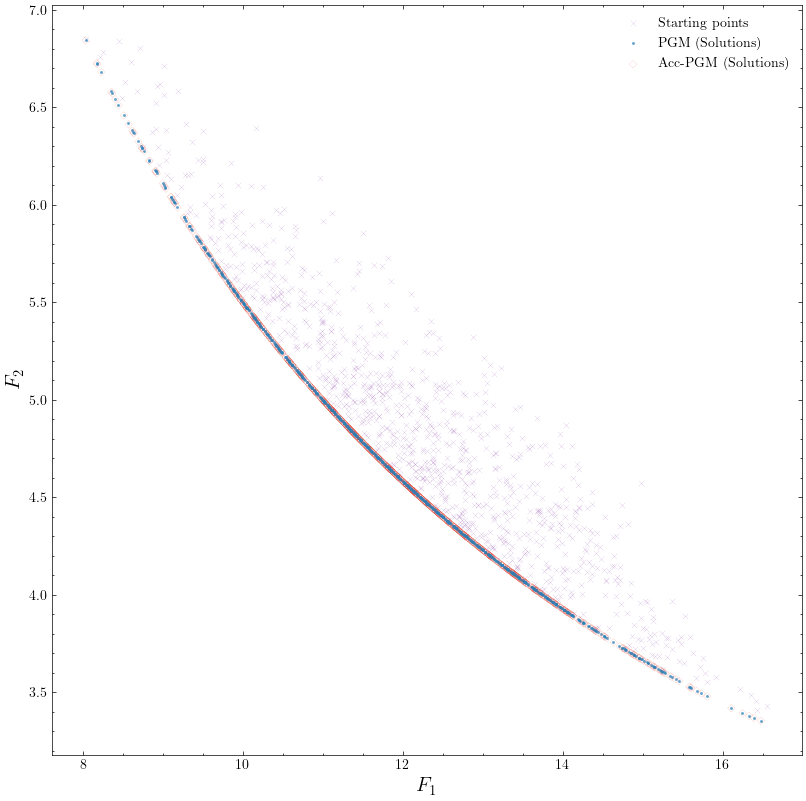

In [21]:
%matplotlib inline
show_Pareto_front(problem_SD, results_SD, results_acc_SD, fname="SD.pdf")

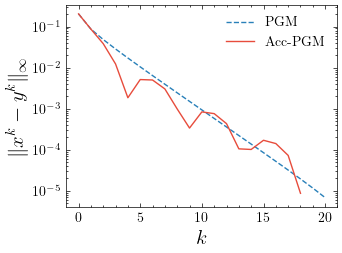

In [22]:
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=15)
plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
plt.plot(
    results_SD[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed"
)
plt.plot(results_acc_SD[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + "/SD_error.pdf", bbox_inches="tight")

## FDS
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}^n$.

In [23]:
n_dims = 10
problem_FDS = FDS(n_dims=n_dims)
start_points_FDS = generate_start_points(low=-2, high=2, n_dims=n_dims)

### Proximal Gradient Method

In [24]:
results_FDS = run(problem_FDS, start_points_FDS)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20

### Accelerated Proximal Gradient Method

In [25]:
results_acc_FDS = run(problem_FDS, start_points_FDS, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7

### Complexity

In [26]:
stats_FDS = {"PGM": get_stats(results_FDS), "Acc-PGM": get_stats(results_acc_FDS)}
pprint.pprint(stats_FDS)

{'Acc-PGM': {'execusion_time': {'max': 39.55773687362671,
                                'mean': 19.32521717119217,
                                'std': 5.735134424591513},
             'nit': {'max': 458, 'mean': 216.824, 'std': 67.05155497078349},
             'nit_internal': {'max': 15778,
                              'mean': 7617.684,
                              'std': 2285.9676896544274}},
 'PGM': {'execusion_time': {'max': 207.85198521614075,
                            'mean': 53.482315192461016,
                            'std': 33.66924945504039},
         'nit': {'max': 2640, 'mean': 598.637, 'std': 413.5841307775239},
         'nit_internal': {'max': 82537,
                          'mean': 21056.817,
                          'std': 13537.800721517178}}}


0it [00:00, ?it/s]

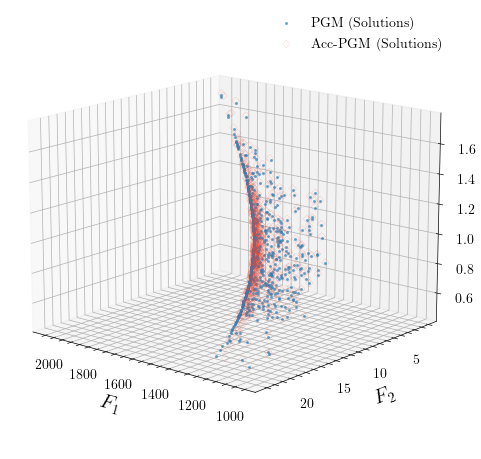

In [27]:
%matplotlib inline
show_Pareto_front(problem_FDS, results_FDS, results_acc_FDS, fname="FDS.pdf")

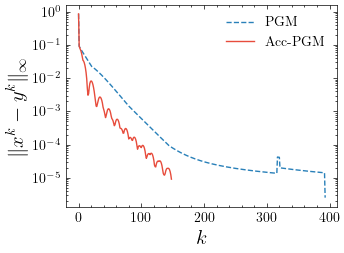

In [28]:
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=15)
plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
plt.plot(
    results_FDS[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed"
)
plt.plot(results_acc_FDS[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + "/FDS_error.pdf", bbox_inches="tight")

## FDS CONSTRAINED
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}_+^n$.

In [29]:
n_dims = 10
problem_FDS_CONSTRAINED = FDS_CONSTRAINED(n_dims=n_dims)
start_points_FDS_CONSTRAINED = generate_start_points(low=0, high=2, n_dims=n_dims)

In [30]:
results_FDS_CONSTRAINED = run(problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 44

In [31]:
results_acc_FDS_CONSTRAINED = run(
    problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED, nesterov=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12

In [32]:
stats_FDS_CONSTRAINED = {
    "PGM": get_stats(results_FDS_CONSTRAINED),
    "Acc-PGM": get_stats(results_acc_FDS_CONSTRAINED),
}
pprint.pprint(stats_FDS_CONSTRAINED)

{'Acc-PGM': {'execusion_time': {'max': 73.01789879798889,
                                'mean': 32.38448367094993,
                                'std': 9.095739273097353},
             'nit': {'max': 651, 'mean': 268.968, 'std': 86.530347139024},
             'nit_internal': {'max': 21000,
                              'mean': 9416.054,
                              'std': 2682.9857385166997}},
 'PGM': {'execusion_time': {'max': 345.1270561218262,
                            'mean': 111.05938012957573,
                            'std': 55.36683633818737},
         'nit': {'max': 3112, 'mean': 934.443, 'std': 506.89862571425465},
         'nit_internal': {'max': 101739,
                          'mean': 32410.08,
                          'std': 16334.077640185258}}}


0it [00:00, ?it/s]

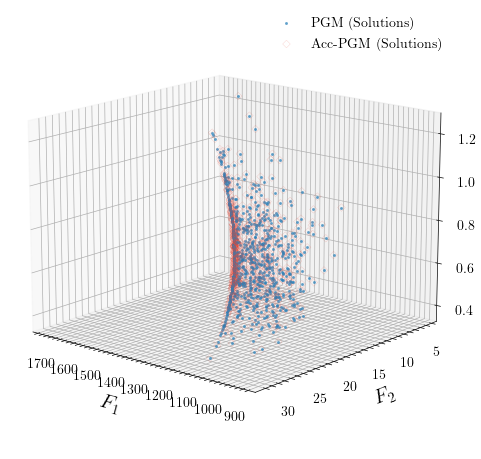

In [33]:
%matplotlib inline
show_Pareto_front(
    problem_FDS_CONSTRAINED,
    results_FDS_CONSTRAINED,
    results_acc_FDS_CONSTRAINED,
    fname="FDS_CONSTRAINED.pdf",
)

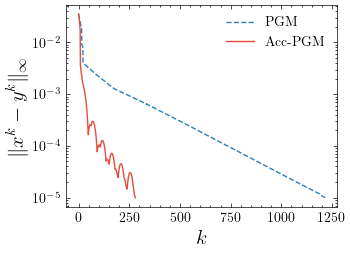

In [34]:
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=15)
plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
plt.plot(
    results_FDS_CONSTRAINED[0].all_error_criteria,
    color="#2980b9",
    label="PGM",
    linestyle="dashed",
)
plt.plot(
    results_acc_FDS_CONSTRAINED[0].all_error_criteria, color="#e74c3c", label="Acc-PGM"
)
plt.legend()
plt.savefig(fig_path + "/FDS_CONSTRAINED_error.pdf", bbox_inches="tight")